## Digit recognizer
#### By: Niv Dobzinski (PhD)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Input
import keras_tuner as kt
import shutil

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#Use two GPUs at parralel
strategy = tf.distribute.MirroredStrategy()

Num GPUs Available:  2


## Get the data

In [4]:
train_file=r"/kaggle/input/digit-recognizer/train.csv"
test_file=r"/kaggle/input/digit-recognizer/test.csv"

In [5]:
train=pd.read_csv(train_file)
test=pd.read_csv(test_file)

In [6]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Seperate the known labels

In [7]:
y = train['label']
X = train.drop(columns=['label'])

In [8]:
X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Normalize the values

In [9]:
X=X/255
X_test=test/255

In [10]:
X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Transform the data into a 2D array

In [11]:
# -1 is to calculate the dimention, 1 is indicating a 1 channel picture
X = X.values.reshape(-1, 28, 28, 1)
X_test=X_test.values.reshape(-1, 28, 28, 1)

### Change y to one hot encoding

In [12]:
y = to_categorical(y, num_classes=10)

In [13]:
# Example
y[3]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

### Split the data to train and validation

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


### Model

In [15]:
def build_model(hp):
    with strategy.scope():
        model = Sequential()
        model.add(Input(shape=(28, 28, 1)))

        # First layer
        model.add(Conv2D(
            filters=hp.Choice('filters_1', values=[32, 64, 128]), 
            kernel_size=hp.Choice('kernel_size_1', values=[3, 5]), 
            activation='relu',
            padding='same'))

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Choice('dropout_rate_1', values=[0.25, 0.5])))

        # Second layer
        model.add(Conv2D(
            filters=hp.Choice('filters_2', values=[64, 128, 256]),
            kernel_size=hp.Choice('kernel_size_2', values=[3, 5]), 
            activation='relu',
            padding='same'))

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Choice('dropout_rate_2', values=[0.25, 0.5])))

        # Third layer
        model.add(Conv2D(
            filters=hp.Choice('filters_3', values=[128, 256, 512]),
            kernel_size=hp.Choice('kernel_size_3', values=[3, 5]), 
            activation='relu',
            padding='same'))

        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Choice('dropout_rate_3', values=[0.25, 0.5])))

        # Output layer    
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(hp.Choice('dropout_rate_3', values=[0.25, 0.5])))
        model.add(Dense(10, activation='softmax'))

        # Compile the model    
        opt = tf.keras.optimizers.Adam()
        model.compile(
            optimizer=opt,
            loss='categorical_crossentropy',  # Use categorical crossentropy for one-hot encoded labels
            metrics=['accuracy'])

        return model


### Augmentation data generator

In [16]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [17]:
# Clear the directory if it exists
if os.path.exists('my_dir/mnist_tuning'):
    shutil.rmtree('my_dir/mnist_tuning')

### Hyperparameter Tuner Setup

In [18]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='mnist_tuning'
)

### Define batch size and epochs

In [19]:
batch_size = 64
epochs = 10

# Calculate steps_per_epoch
steps_per_epoch = X_train.shape[0] // batch_size

### Custom generator to yield one-hot encoding labels.
#### Yeald batches of training data along with their one hot encoding labels

In [20]:
def custom_generator(datagen, X_train, y_train, batch_size):
    gen = datagen.flow(X_train, y_train, batch_size=batch_size)
    while True:
        X_batch, y_batch = next(gen)
        yield X_batch, y_batch

### Creating a TensorFlow Dataset from a Custom Data Generator

In [21]:
train_data_tf = tf.data.Dataset.from_generator(
    lambda: custom_generator(datagen, X_train, y_train, batch_size=batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 10), dtype=tf.float32)  # One-hot encoded labels
    )
).repeat()

### Perform hyperparameter search with data augmentation

In [22]:
tuner.search(
    train_data_tf,
    epochs=epochs,
    validation_data=(X_val, y_val),
    steps_per_epoch=steps_per_epoch,
    verbose=1
)

Trial 20 Complete [00h 02m 49s]
val_accuracy: 0.9885714054107666

Best val_accuracy So Far: 0.9923809766769409
Total elapsed time: 00h 56m 11s


### (Best val_accuracy So Far: 0.9923809766769409)

### Retrieve the best hyperparameters

In [23]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("The best hyperparameters are:")
print(f"filters_1: {best_hps.get('filters_1')}")
print(f"kernel_size_1: {best_hps.get('kernel_size_1')}")
print(f"dropout_rate_1: {best_hps.get('dropout_rate_1')}")
print(f"filters_2: {best_hps.get('filters_2')}")
print(f"kernel_size_2: {best_hps.get('kernel_size_2')}")
print(f"dropout_rate_2: {best_hps.get('dropout_rate_2')}")
print(f"filters_3: {best_hps.get('filters_3')}")
print(f"kernel_size_3: {best_hps.get('kernel_size_3')}")
print(f"dropout_rate_3: {best_hps.get('dropout_rate_3')}")
# print(f"optimizer: {best_hps.get('optimizer')}")

The best hyperparameters are:
filters_1: 128
kernel_size_1: 5
dropout_rate_1: 0.25
filters_2: 128
kernel_size_2: 3
dropout_rate_2: 0.25
filters_3: 256
kernel_size_3: 3
dropout_rate_3: 0.25


### Define the function to build the final model using best hyperparameters

In [26]:
def build_final_model(hp):
    model = Sequential()
    model.add(Input(shape=(28, 28, 1)))
    
    # First layer
    model.add(Conv2D(
        filters=hp.get('filters_1'), 
        kernel_size=hp.get('kernel_size_1'), 
        activation='relu',
        padding='same'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.get('dropout_rate_1')))

    # Second layer
    model.add(Conv2D(
        filters=hp.get('filters_2'),
        kernel_size=hp.get('kernel_size_2'), 
        activation='relu',
        padding='same'))
        
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.get('dropout_rate_2')))

    # Third layer
    model.add(Conv2D(
        filters=hp.get('filters_3'),
        kernel_size=hp.get('kernel_size_3'), 
        activation='relu',
        padding='same'))
        
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.get('dropout_rate_3')))
    
    # Output layer    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
      
    # Compile the model    
    opt = tf.keras.optimizers.Adam()
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',  # Use categorical crossentropy for one-hot encoded labels
        metrics=['accuracy'])
    
    return model

### Build the final model using the best hyperparameters

In [27]:
final_model = build_final_model(best_hps)

### Train the model

In [ ]:
history = final_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, y_val),
    steps_per_epoch=X_train.shape[0] // batch_size,
    verbose=1
)

### Predict

In [ ]:
predictions = final_model.predict(X_test)
# Convert predictions from one-hot encoding to integer labels
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

### Evaluate

In [34]:
import matplotlib.pyplot as plt

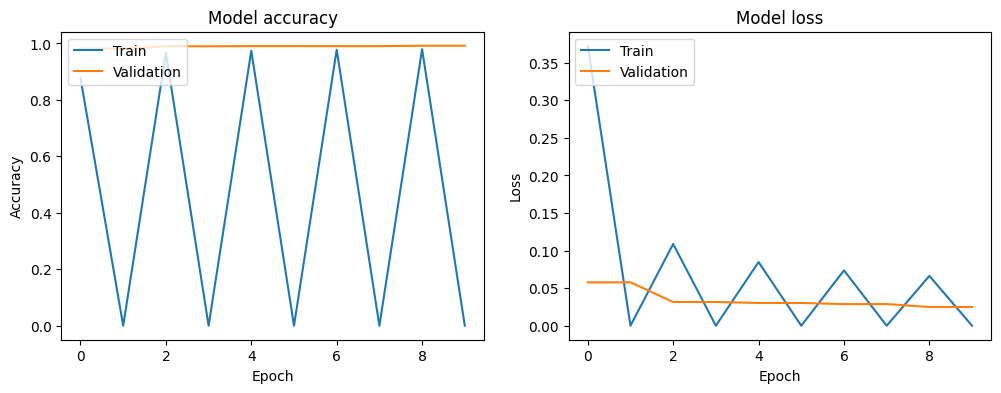

In [35]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


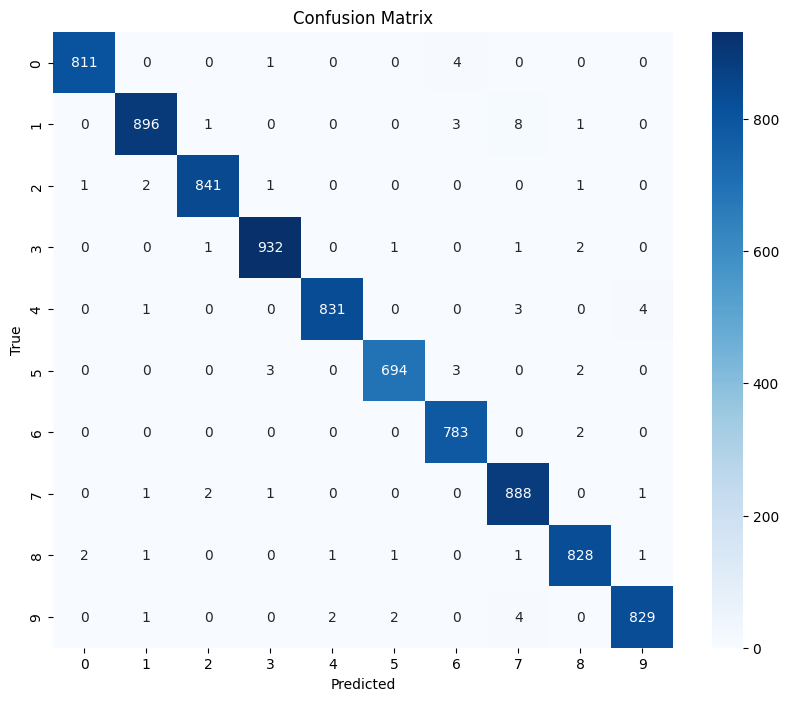

In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on the validation set
val_predictions = final_model.predict(X_val)
val_predicted_classes = np.argmax(val_predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=1), val_predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Creating and Saving a Submission File

In [37]:
# Create a DataFrame for the submission
submission = pd.DataFrame({
    'ImageId': range(1, len(predicted_labels) + 1),  # ImageId should start from 1
    'Label': predicted_labels
})

# Save the DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)

- **Kaggle Competition Accuracy Score:** 0.99046

- **Public Leaderboard Score:** Top 24%

![Kaggle Score](Kaggle_compatition_score.png)